# Raytracing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
w = 800
h = 600
img = np.zeros((h, w, 3))

Ray-tracer lesson from scratchapixel.com is taken as reference here.

First start with the ray-plane intersection, which is defined by the folloiwng equation:

\begin{array}{l}l * t \cdot n + (l_0 - p_o) \cdot n = 0\\t = -{\dfrac{(l_0-p_0)\cdot n}{l \cdot n}} = {\dfrac{(p_0 - l_0) \cdot n}{l \cdot n}}\end{array}

In the function below when the denominator (product of ray direction vector and the normal) gets very small or in the case when $t$ is negative when ray and plane coincide, return infinity. Otherwise, return the ditance from origin $o$ to the intersection of the ray with the plane passing through $p$ with the normal $n$


In [3]:
def plane_t(o, l, p, n):
    d = np.dot(l, n)
    if np.abs(d) < 1e-6:
        return np.inf
    t = np.dot(p - o, n)/d
    if t < 0:
        return np.inf
    return t

In a similar fashion define the ray-triangle inersection using the barycentric coordinates. For that purpose one will need to find $u$ and $v$ (as any point in the triangle is defined as $P=uA+vB+wC.$

The barycentric coordinates can be found from their connection with area. In case of a triangle with vertices $A$, $B$ and $C$ and point $P$ lying inside, $u$ and $v$ can be found from:

\begin{array}{l}
u = {\dfrac{TriangleCAP_{Area}}{TriangleABC_{Area}}}\\
v = {\dfrac{TriangleABP_{Area}}{TriangleABC_{Area}}}\\
\end{array}

In [4]:
def triangle_t(o, d, p, n):
    #check the intersection of the ray with one of the vertices
    t = plane_t(o[0], d, np.array(p[0]), n);
    if (t == np.inf):
        return np.inf
    #assuming the t is not infinity, define the intersection point
    i = o + d*t
    #define the edges
    e0 = np.array(p[2]) - np.array(p[0])
    e1 = np.array(p[1]) - np.array(p[0])
    e2 = i - np.array(p[0])
    d00 = np.dot(e0, e0)
    d01 = np.dot(e0, e1)
    d02 = np.dot(e0, e2)
    d11 = np.dot(e1, e1)
    d12 = np.dot(e1, e2)
    #calculate  u and v and check whether the point p lies inside the triangle
    #in order for t to lie inside the triangle, both u and v should be positive
    #and their sum should be less than 1, since u + v + w = 1
    dn = d00 * d11 - d01 * d01
    u = (d11 * d02 - d01 * d12) / dn
    v = (d00 * d12 - d01 * d02) / dn
    
    if (u >= 0) and (v >= 0) and (u + v < 1):
        return t
    else:
        return np.inf

For the ray-sphere intersection use the equation given by $O^2+(Dt)^2+2ODt-R^2=O^2+D^2t^2+2ODt-R^20$ and solve a quadratic equation

In [5]:
def sphere_t(o, d, sphere, r):
    #define the a, b and c
    a = np.dot(d, d)
    b = 2*np.dot(d, (o - sphere))
    c = np.dot((o - sphere), (o - sphere)) - r*r
    #find the roots of the quadratic equation
    discriminant = b*b - 4*a*c
    if discriminant > 0:
        if b < 0:
            root = (-b - np.sqrt(discriminant))*0.5
        else:
            root = (-b + np.sqrt(discriminant))*0.5
        t0 = root / a
        t1 = c / root
        #defint t0 to be the minimum of the two and t1 to be the maximum of the two
        t0, t1 = min(t0, t1), max(t0, t1)
        if t1 >= 0:
            if t0 < 0:
                return t1
            else:
                return t0
    return np.inf

Define fucntions for calculating the Phong Lighting:

In [6]:
def calc_diffuse(diffuse_intensity, n, l, color):
    return diffuse_intensity*max(np.dot(n, l), 0)*color

def calc_specular(specular_intensity, n, l, o, coeff, color):
    return specular_intensity*max(np.dot(n, normalize(l + o)), 0)**coeff*color

The following function finds the necessary $t$ depending on the object type (i.e., sphere, triangle, plane)

In [7]:
def find_t(origin, direction, obj):
    if obj['type'] == 'plane':
        return plane_t(origin, direction, obj['position'], obj['normal'])
    elif obj['type'] == 'sphere':
        return sphere_t(origin, direction, obj['position'], obj['radius'])
    elif obj['type'] == 'triangle':
        return triangle_t(origin, direction, obj['position'], obj['normal'])
    elif obj['type'] == 'sphere':
        return sphere_t(origin, direction, obj['position'], obj['radius'])

Normalize the vector elements to be in the range [0,  1].

In [8]:
def normalize(x):
    x /= np.linalg.norm(x)
    return x

The following function returns the casted rays. It takes as input the origin and the direction vector of the camera and returns the sampled color of the object with the casted ray. 

It first checks whether there is an object to be intersected. 
If there is one the point of intersection is given by $M = O + D\cdot t$

Depending on the point of intersection, the normal to the object (sphere, triangle or plane) and its color are calculated. 

In [9]:
def cast_ray(origin, direction, L):
    t = np.inf
    #find the first object to be intersected
    #then get the object number and its normal and color
    for i, obj in enumerate(scene):
        t_cur = find_t(origin, direction, obj)
        if t_cur < t:
            t, num = t_cur, i
    if t == np.inf:
        return
    obj = scene[num]
    M = origin + direction * t
    if obj['type'] == 'sphere':
        N = normalize(M - obj['position'])
    elif obj['type'] == 'plane':
        N = obj['normal']
    elif obj['type'] == 'triangle':
        N = obj['normal']
    color = obj['color']
    if not hasattr(color, '__len__'):
        color = color(M)
    #color of ray calculated by Phong model. Initial value taken as ambient
    new_color = ambient
    light_num = 0
    for light_num in range(len(L)):
        light = normalize(L[light_num] - M)
        camera = normalize(camera_pos - M)
        l = [find_t(M + N * .0001, light, shadow) 
                for k, shadow in enumerate(scene) if k != num]
        if l and min(l) < np.inf:
            pass
        else:
            new_color += calc_diffuse(obj.get('diffuse_c', diffuse_c), N, light, color) + calc_specular(obj.get('specular_c', specular_c), N, light, camera, specular_k, color_light[light_num])
    return obj, M, N, new_color


The following function is usde to create the checkerboard effect on the plane. The squares whose row index and column index are either both even or both odd are painted black, the rest are white. 

In [10]:
def checkerboard(p):
    if(int(p[0] * 2) % 2) == (int(p[2] * 2) % 2):
        color = 1.0*np.ones(3)
    else:
        color = 0.0*np.ones(3)
    return color

Display function shows the image that was saved as a numpy array as an image in the notebook:

In [11]:
def display(img):
    return Image.fromarray((img*255).astype('uint8'))

In [12]:
r = float(w) / h #aspect ratio taken as a floating point

The following function is used to create a dicitonary for a selected object

In [13]:
def new_sphere(position, radius, color, diffuse = 0.7, specular = 0.5, ref = 0.5):
    return dict(type='sphere', position=np.array(position), 
        radius=np.array(radius), color=np.array(color), reflection = ref, diffuse_c = diffuse, specular_c = specular)
    
def new_plane(position, normal):
    return dict(type='plane', position=np.array(position), 
        normal=np.array(normal),
        color=lambda M: (white 
            if (int(M[0] * 2) % 2) == (int(M[2] * 2) % 2) else black),
        diffuse_c=.75, specular_c=.5, reflection=.5)
    
def new_triangle(v1, v2, v3, color,  diffuse = 0.75, specular = 0.5, ref = 0.1):
    u = np.subtract(v2,v1)
    v = np.subtract(v3,v1)
    n = np.cross(u,v)
    return dict(type='triangle', position=(v1, v2, v3),
        color=np.array(color), reflection = ref, diffuse_c = diffuse, specular_c = specular, normal=n)

Create the scene by listing objects and lights, as well as setting the position of the camera and the direction it is pointing to.

The materials of the objects in the scene are defined by the lighting model parameters. This particular scene features three spheres, one of them is almost mirror-like with the  aximum reflection parameter, the middle one reflects only a small portion of the light whereas the last one represents a matte object with no light being reflected from it:

In [14]:
white = 1. * np.ones(3)
black = 0 * np.ones(3)
scene = [new_plane([0., -.5, 0.], [0., 1., 0.]),
    new_sphere([.75, .1, 1.], .6, [0.0, 0.0, 0.0], 1.0, 1.0, 1.0), 
    new_sphere([-.75, .1, 2.25], .6, [0.0, 0.7, 0.7], 0.7, 0.5, 0.05),
    new_sphere([-2.75, .1, 3.5], .6, [1., .572, .184], 0.5, 0.5, 0.0)]

In [15]:
lights = np.array([[5.0, 5.0, -10.0],[-10.0, 20.0, -10.0],[-10.0, 1.0, -10.0]])
color_light = np.array([[1., 1., 1.],[0.0, 1.0, 0.0],[1.0, 0.0, 0.0]])

Define the default light coefficients for the Phong model. If they are not already define inside the objects themselves, the script will use these parametrs instead.

In [16]:
ambient = .05
diffuse_c = 1.
specular_c = 1.
specular_k = 50

Camera parameters:

In [17]:
camera_pos = np.array([0., 0.35, -1.])
camera_dir = np.array([0., 0., 0.])

Specify the maximum number for recursion of reflection and the current default color:

In [18]:
depth_max = 6
col = np.zeros(3)  

The following loop iterates over all of the pixels and inside iterates over the rays to create reflections.
The screen coordinates are given via aspect ratio.
The loop takes a while (1-3 minutes) to complete, depending on the number of onjects in the scene.

In [19]:
for i, x in enumerate(np.linspace(-1.0, 1.0, w)):
    for j, y in enumerate(np.linspace(-1.0/r + 0.25, 1.0/r + 0.25, h)):
        col[:] = 0
        camera_dir[:2] = (x, y)
        D = normalize(camera_dir - camera_pos)
        reflection = 1.0
        depth = 0
        origin, direction = camera_pos, D
        while depth < depth_max:
            traced = cast_ray(origin, direction, lights)
            if not traced:
                break
            obj, M, N, col_ray = traced
            # Reflection: create a new ray.
            origin, direction = M + N * .0001, normalize(direction - 2 * np.dot(direction, N) * N)
            depth += 1
            col += reflection * col_ray
            reflection *= obj.get('reflection', 1.)
        img[h - j - 1, i, :] = np.clip(col, 0, 1)

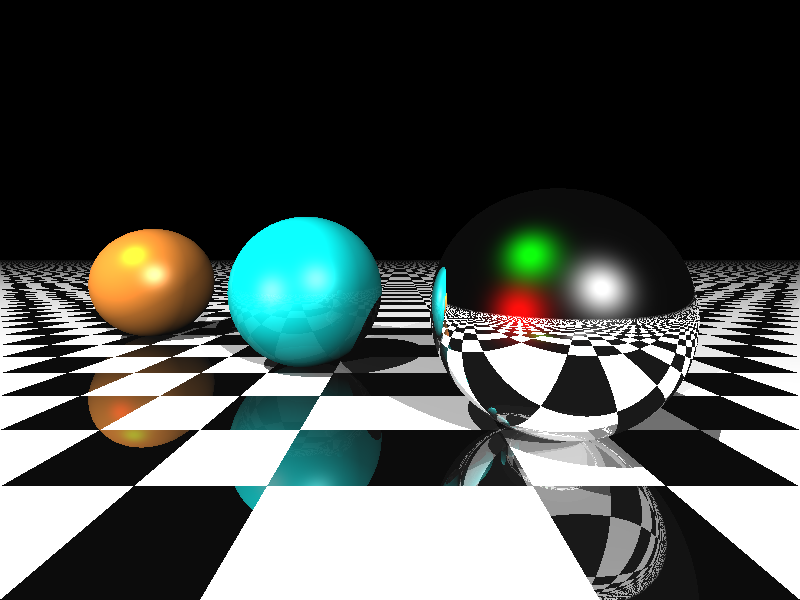

In [20]:
display(img)